In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
plt.rcParams["figure.figsize"] = (20,5) # 设置pyplot绘制的图片大小

In [42]:
lgb.__version__

'4.0.0'

## 数据获取并处理

In [6]:
#load_dataset
lanes = pd.read_csv('../data/Lane.csv')  
light = pd.read_csv('../data/Light_status.csv')
roads = pd.read_csv('../data/Entrance_road.csv') 
flow = pd.read_csv('../data/Flow.csv')

## Light_status.csv

In [7]:
light.head()

,CYCLE_START_TIME,STAGE_START_TIME,STAGE_END_TIME,STAGE_LENGTH,GREEN_TIME,GREEN_FLASH_TIME,YELLOW_TIME,ALL_RED_TIME,CHANNELS,LANES,PHASES,LANE_FUNCS
0,2023-08-01 0:01:08,2023-08-01 00:01:08,2023-08-01 00:01:30,22,19,0,3,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13"
1,2023-08-01 0:02:18,2023-08-01 00:02:18,2023-08-01 00:02:40,22,19,0,3,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13"
2,2023-08-01 0:04:38,2023-08-01 00:04:38,2023-08-01 00:05:00,22,19,0,3,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13"
3,2023-08-01 0:05:48,2023-08-01 00:05:48,2023-08-01 00:06:10,22,19,0,3,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13"
4,2023-08-01 0:06:58,2023-08-01 00:06:58,2023-08-01 00:07:20,22,19,0,3,0,"11,2,3,10","1_2,1_3,3_2,1_4,3_3,3_4","3,5,10","11,13"


In [8]:
# 转换成日期属性
light['CYCLE_START_TIME'] = pd.to_datetime(light['CYCLE_START_TIME'])
light['STAGE_START_TIME'] = pd.to_datetime(light['STAGE_START_TIME'])
light['STAGE_END_TIME'] = pd.to_datetime(light['STAGE_END_TIME'])

In [9]:
# 删除GREEN_FLASH_TIME YELLOW_TIME无用列
light.drop('GREEN_FLASH_TIME',axis=1,inplace=True)
light.drop('YELLOW_TIME',axis=1,inplace=True)

In [10]:
# 将LANES列转为对应的1W 1E 2W形式
light['released_lanes'] = light['LANES'].str.split(',') # 用，分割

In [11]:
# 将放行车道号“_”前代表的进口道，1，2，3，4替换为为W，N，E，S。

# 定义一个替换函数 replace_dir
def replace_lanes(lanes):
    replaced = []
    for i in lanes:
        i = i.replace('1_', 'W_')
        i = i.replace('2_', 'N_')
        i = i.replace('3_', 'E_')
        i = i.replace('4_', 'S_')
        
        replaced.append(i)
    
    return replaced

# apply替换
light['released_lanes'] = light['released_lanes'].apply(replace_lanes)

In [12]:
# 调换顺序，改为前面为车道号，后面为进口道，并去掉下划线
light['released_lanes'] = light['released_lanes'].apply(lambda lanes: [lane.replace('_', '')[-1] + lane.replace('_', '')[:-1] for lane in lanes])

In [13]:
# 按LANES分组
lanes_unique = light['LANES'].unique()
lanes_unique

array(['1_2,1_3,3_2,1_4,3_3,3_4', '1_1,3_1', '2_2,2_3,2_4,4_2,4_3,4_4',
       '2_1,4_1'], dtype=object)

In [14]:
# 按LANES分组
ligth_2W3W2E4W3E4E=light[light['LANES']=='1_2,1_3,3_2,1_4,3_3,3_4']
ligth_1W1E=light[light['LANES']=='1_1,3_1']
ligth_2N3N4N2S3S4S=light[light['LANES']=='2_2,2_3,2_4,4_2,4_3,4_4']
ligth_1N1S=light[light['LANES']=='2_1,4_1']

In [15]:
# 删除STAGE_END_TIME，LANES
ligth_2W3W2E4W3E4E.drop(['STAGE_END_TIME','LANES'],axis=1,inplace=True)
ligth_1W1E.drop(['STAGE_END_TIME','LANES'],axis=1,inplace=True)
ligth_2N3N4N2S3S4S.drop(['STAGE_END_TIME','LANES'],axis=1,inplace=True)
ligth_1N1S.drop(['STAGE_END_TIME','LANES'],axis=1,inplace=True)

d:\Development\anaconda3\envs\ml\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
# ligth_2W3W2E4W3E4E
# 删除2023-08-01 00:05:00前的数据
ligth_2W3W2E4W3E4E=ligth_2W3W2E4W3E4E.drop(index=ligth_2W3W2E4W3E4E.index[:3])
ligth_2W3W2E4W3E4E=ligth_2W3W2E4W3E4E.reset_index(drop=True)
# 将CYCLE_START_TIME设置为时间索引
ligth_2W3W2E4W3E4E=ligth_2W3W2E4W3E4E.set_index('CYCLE_START_TIME')
# 对数据进行重新采样，以五分钟为一个时间段，并选择从00:05:00开始的数据：
start_time = pd.to_datetime("2023-08-01 00:05:00")
ligth_2W3W2E4W3E4E = ligth_2W3W2E4W3E4E.resample('5Min',label='left', closed='right').first().loc[start_time:] 

In [17]:
# ligth_1W1E
# 删除2023-08-01 00:05:00前的数据
ligth_1W1E=ligth_1W1E.drop(index=ligth_1W1E.index[:3])
ligth_1W1E=ligth_1W1E.reset_index(drop=True)
# 将CYCLE_START_TIME设置为时间索引
ligth_1W1E=ligth_1W1E.set_index('CYCLE_START_TIME')
# 对数据进行重新采样，以五分钟为一个时间段，并选择从00:05:00开始的数据：
start_time = pd.to_datetime("2023-08-01 00:05:00")
ligth_1W1E = ligth_1W1E.resample('5Min',label='left', closed='right').first().loc[start_time:] 

In [18]:
# ligth_2N3N4N2S3S4S
# 删除2023-08-01 00:05:00前的数据
ligth_2N3N4N2S3S4S=ligth_2N3N4N2S3S4S.drop(index=ligth_2N3N4N2S3S4S.index[:3])
ligth_2N3N4N2S3S4S=ligth_2N3N4N2S3S4S.reset_index(drop=True)
# 将CYCLE_START_TIME设置为时间索引
ligth_2N3N4N2S3S4S=ligth_2N3N4N2S3S4S.set_index('CYCLE_START_TIME')
# 对数据进行重新采样，以五分钟为一个时间段，并选择从00:05:00开始的数据：
start_time = pd.to_datetime("2023-08-01 00:05:00")
ligth_2N3N4N2S3S4S = ligth_2N3N4N2S3S4S.resample('5Min',label='left', closed='right').first().loc[start_time:] 

In [19]:
# ligth_1N1S
# 删除2023-08-01 00:05:00前的数据
ligth_1N1S=ligth_1N1S.drop(index=ligth_1N1S.index[:3])
ligth_1N1S=ligth_1N1S.reset_index(drop=True)
# 将CYCLE_START_TIME设置为时间索引
ligth_1N1S=ligth_1N1S.set_index('CYCLE_START_TIME')
# 对数据进行重新采样，以五分钟为一个时间段，并选择从00:05:00开始的数据：
start_time = pd.to_datetime("2023-08-01 00:05:00")
ligth_1N1S = ligth_1N1S.resample('5Min',label='left', closed='right').first().loc[start_time:] 

## Flow.csv

In [20]:
flow['START_TIME'] = pd.to_datetime(flow['START_TIME'])
flow['END_TIME'] = pd.to_datetime(flow['END_TIME'])

In [21]:
flow['LANE_ARM']=flow['LANE_ID'].astype(str)+flow['ARM_ID']

In [22]:
lane_arm = flow.pop("LANE_ARM")
flow.insert(2,'LANE_ARM',lane_arm)

In [23]:
flow.drop(['LANE_ID','ARM_ID'],axis = 1,inplace = True)

In [24]:
LANE_ARM_uniqe =flow['LANE_ARM'].unique()
LANE_ARM_uniqe

array(['1E', '1N', '1S', '1W', '2E', '2N', '2S', '2W', '3E', '3N', '3S',
       '3W', '4E', '4N', '4S', '4W'], dtype=object)

In [25]:
# 按LANE_ARM分组
flow_1E = flow[flow['LANE_ARM']=='1E']
flow_1N = flow[flow['LANE_ARM']=='1N']
flow_1S = flow[flow['LANE_ARM']=='1S']
flow_1W = flow[flow['LANE_ARM']=='1W']
flow_2E = flow[flow['LANE_ARM']=='2E']
flow_2N = flow[flow['LANE_ARM']=='2N']
flow_2S = flow[flow['LANE_ARM']=='2S']
flow_2W = flow[flow['LANE_ARM']=='2W']
flow_3E = flow[flow['LANE_ARM']=='3E']
flow_3N = flow[flow['LANE_ARM']=='3N']
flow_3S = flow[flow['LANE_ARM']=='3S']
flow_3W = flow[flow['LANE_ARM']=='3W']
flow_4E = flow[flow['LANE_ARM']=='4E']
flow_4N = flow[flow['LANE_ARM']=='4N']
flow_4S = flow[flow['LANE_ARM']=='4S']
flow_4W = flow[flow['LANE_ARM']=='4W']

In [26]:
flow_LANE_ARM = [flow_1E
,flow_1N
,flow_1S
,flow_1W
,flow_2E
,flow_2N
,flow_2S
,flow_2W
,flow_3E
,flow_3N
,flow_3S
,flow_3W
,flow_4E
,flow_4N
,flow_4S
,flow_4W]

In [27]:
flow_1E = flow_1E.set_index('START_TIME')
flow_1N = flow_1N.set_index('START_TIME')
flow_1S = flow_1S.set_index('START_TIME')
flow_1W = flow_1W.set_index('START_TIME')
flow_2E = flow_2E.set_index('START_TIME')
flow_2N = flow_2N.set_index('START_TIME')
flow_2S = flow_2S.set_index('START_TIME')
flow_2W = flow_2W.set_index('START_TIME')
flow_3E = flow_3E.set_index('START_TIME')
flow_3N = flow_3N.set_index('START_TIME')
flow_3S = flow_3S.set_index('START_TIME')
flow_3W = flow_3W.set_index('START_TIME')
flow_4E = flow_4E.set_index('START_TIME')
flow_4N = flow_4N.set_index('START_TIME')
flow_4S = flow_4S.set_index('START_TIME')
flow_4W = flow_4W.set_index('START_TIME')

In [28]:
merged_flow_1E = pd.merge(flow_1E,ligth_1W1E, left_index=True, right_index=True, how='left')
merged_flow_1N = pd.merge(flow_1N,ligth_1N1S, left_index=True, right_index=True, how='left')
merged_flow_1S = pd.merge(flow_1S,ligth_1N1S, left_index=True, right_index=True, how='left')
merged_flow_1W = pd.merge(flow_1W,ligth_1W1E, left_index=True, right_index=True, how='left')
merged_flow_2E = pd.merge(flow_2E,ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_flow_2N = pd.merge(flow_2N,ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_flow_2S = pd.merge(flow_2S,ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_flow_2W = pd.merge(flow_2W,ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_flow_3E = pd.merge(flow_3E,ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_flow_3N = pd.merge(flow_3N,ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_flow_3S = pd.merge(flow_3S,ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_flow_3W = pd.merge(flow_3W,ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_flow_4E = pd.merge(flow_4E,ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')
merged_flow_4N = pd.merge(flow_4N,ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_flow_4S = pd.merge(flow_4S,ligth_2N3N4N2S3S4S, left_index=True, right_index=True, how='left')
merged_flow_4W = pd.merge(flow_4W,ligth_2W3W2E4W3E4E, left_index=True, right_index=True, how='left')

In [29]:
df_1E = merged_flow_1E.copy()
df_1N = merged_flow_1N.copy()
df_1S = merged_flow_1S.copy()
df_1W = merged_flow_1W.copy()
df_2E = merged_flow_2E.copy()
df_2N = merged_flow_2N.copy()
df_2S = merged_flow_2S.copy()
df_2W = merged_flow_2W.copy()
df_3E = merged_flow_3E.copy()
df_3N = merged_flow_3N.copy()
df_3S = merged_flow_3S.copy()
df_3W = merged_flow_3W.copy()
df_4E = merged_flow_4E.copy()
df_4N = merged_flow_4N.copy()
df_4S = merged_flow_4S.copy()
df_4W = merged_flow_4W.copy()

In [30]:
df_1E

,LANE_ARM,END_TIME,VOLUMN_5MIN,STAGE_START_TIME,STAGE_LENGTH,GREEN_TIME,ALL_RED_TIME,CHANNELS,PHASES,LANE_FUNCS,released_lanes
START_TIME,,,,,,,,,,,
2023-08-01 00:05:00,1E,2023-08-01 00:10:00,2,2023-08-01 00:06:10,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:10:00,1E,2023-08-01 00:15:00,1,2023-08-01 00:10:50,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:15:00,1E,2023-08-01 00:20:00,0,2023-08-01 00:15:30,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:20:00,1E,2023-08-01 00:25:00,1,2023-08-01 00:21:20,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-01 00:25:00,1E,2023-08-01 00:30:00,0,2023-08-01 00:26:00,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27 23:35:00,1E,2023-08-27 23:40:00,1,2023-08-27 23:35:33,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-27 23:40:00,1E,2023-08-27 23:45:00,0,2023-08-27 23:41:23,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"
2023-08-27 23:45:00,1E,2023-08-27 23:50:00,0,2023-08-27 23:46:03,13.0,9.0,1.0,"1,9","4,9",12,"[1W, 1E]"


## 合并车流量

In [31]:
LANE_ARM = [
flow_1N
,flow_1S
,flow_1W
,flow_2E
,flow_2N
,flow_2S
,flow_2W
,flow_3E
,flow_3N
,flow_3S
,flow_3W
,flow_4E
,flow_4N
,flow_4S
,flow_4W]

merged_flow = flow_1E['VOLUMN_5MIN']
merged_flow = pd.DataFrame(merged_flow)
for i in LANE_ARM:
    merged_flow['VOLUMN_5MIN'] = merged_flow['VOLUMN_5MIN']+i['VOLUMN_5MIN']
    
merged_flow

,VOLUMN_5MIN
START_TIME,
2023-08-01 00:05:00,7.0
2023-08-01 00:10:00,11.0
2023-08-01 00:15:00,6.0
2023-08-01 00:20:00,9.0
2023-08-01 00:25:00,2.0
...,...
2023-08-27 23:35:00,14.0
2023-08-27 23:40:00,6.0
2023-08-27 23:45:00,2.0


# 构造训练数据

In [34]:
import pandas as pd
data = merged_flow.copy()

In [66]:

# 设置时间窗口大小
window_size = 20

In [67]:

# 滑动时间窗口生成样本
samples = []
for i in range(len(data) - window_size):
    window_data = data.iloc[i:i+window_size]
    features = window_data['VOLUMN_5MIN'].values # 提取特征
    target = data.iloc[i+window_size]['VOLUMN_5MIN'] # 提取目标值
    samples.append((features, target))

# 划分训练集和测试集
train_samples = samples[:int(0.8 * len(samples))] # 取80%作为训练集
test_samples = samples[int(0.8 * len(samples)):] # 剩余20%作为测试集

# 构建特征矩阵和目标向量
train_X = [sample[0] for sample in train_samples]
train_y = [sample[1] for sample in train_samples]
test_X = [sample[0] for sample in test_samples]
test_y = [sample[1] for sample in test_samples]


In [68]:
train_X=pd.DataFrame(train_X)

In [69]:
train_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,7.0,11.0,6.0,9.0,2.0,9.0,4.0,4.0,11.0,4.0,4.0,5.0,3.0,3.0,2.0,5.0,5.0,3.0,5.0,7.0
1,11.0,6.0,9.0,2.0,9.0,4.0,4.0,11.0,4.0,4.0,5.0,3.0,3.0,2.0,5.0,5.0,3.0,5.0,7.0,4.0
2,6.0,9.0,2.0,9.0,4.0,4.0,11.0,4.0,4.0,5.0,3.0,3.0,2.0,5.0,5.0,3.0,5.0,7.0,4.0,0.0
3,9.0,2.0,9.0,4.0,4.0,11.0,4.0,4.0,5.0,3.0,3.0,2.0,5.0,5.0,3.0,5.0,7.0,4.0,0.0,2.0
4,2.0,9.0,4.0,4.0,11.0,4.0,4.0,5.0,3.0,3.0,2.0,5.0,5.0,3.0,5.0,7.0,4.0,0.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6018,78.0,91.0,84.0,73.0,106.0,107.0,112.0,118.0,116.0,127.0,118.0,134.0,143.0,121.0,78.0,136.0,123.0,114.0,117.0,107.0
6019,91.0,84.0,73.0,106.0,107.0,112.0,118.0,116.0,127.0,118.0,134.0,143.0,121.0,78.0,136.0,123.0,114.0,117.0,107.0,113.0
6020,84.0,73.0,106.0,107.0,112.0,118.0,116.0,127.0,118.0,134.0,143.0,121.0,78.0,136.0,123.0,114.0,117.0,107.0,113.0,140.0
6021,73.0,106.0,107.0,112.0,118.0,116.0,127.0,118.0,134.0,143.0,121.0,78.0,136.0,123.0,114.0,117.0,107.0,113.0,140.0,116.0


In [70]:
train_y=pd.DataFrame(train_y)
test_X =pd.DataFrame(test_X)
test_y =pd.DataFrame(test_y)

In [71]:
train_X.info()
train_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6023 entries, 0 to 6022
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6022 non-null   float64
 1   1       6022 non-null   float64
 2   2       6022 non-null   float64
 3   3       6022 non-null   float64
 4   4       6022 non-null   float64
 5   5       6022 non-null   float64
 6   6       6022 non-null   float64
 7   7       6022 non-null   float64
 8   8       6022 non-null   float64
 9   9       6022 non-null   float64
 10  10      6022 non-null   float64
 11  11      6022 non-null   float64
 12  12      6022 non-null   float64
 13  13      6022 non-null   float64
 14  14      6022 non-null   float64
 15  15      6022 non-null   float64
 16  16      6022 non-null   float64
 17  17      6022 non-null   float64
 18  18      6022 non-null   float64
 19  19      6022 non-null   float64
dtypes: float64(20)
memory usage: 941.2 KB
<class 'pandas.core.frame.DataFrame'

### 调参和训练

首先，导入LightGBM的python包。

接着，创建训练数据和测试数据，代码如下。导入数据集之后，LightGBM会根据超参数，在数据集中加入一些额外的结构信息，例如，哪些特征属于类别特征、特征值离散化的边界等等。创建test_set时，我们需要设置reference=train_set，这使得test_set的结构信息与train_set保持一致。

`feature_pre_filter`默认为`True`，lightgbm会根据min_data_in_leaf的值提前把一些不可能找到合法分割的特征过滤。由于后面会调整min_data_in_leaf，我们不希望反复构造数据集，我们将设置`feature_pre_filter=False`，这样`min_data_in_leaf`的选取不会影响到Dataset的构建。

In [72]:

#train_set = lgb.Dataset(train_X, label=train_y)
#test_set = lgb.Dataset(test_X, label=test_y)

In [73]:
params = {
    "feature_pre_filter": False
}

train_set = lgb.Dataset(train_X, label=train_y, params=params)
test_set = lgb.Dataset(test_X, label=test_y, reference=train_set)

首先使用一组默认的超参数训练一下，观察在测试集上的效果。

In [75]:
params = {
    'objective':'regression' #设置目标函数为regression，将会使用最小均方误差(MSE)作为目标函数。其他超参数保持默认。
}
model = lgb.train(params=params, train_set=train_set, valid_sets=[test_set], valid_names=["test"])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2883
[LightGBM] [Info] Number of data points in the train set: 6023, number of used features: 20
[LightGBM] [Info] Start training from score 47.806907


#### 手动调参

调参时，将train_set中最后一天288个数据作为验证集，其余作为训练集。

In [ ]:
'''
#划分训练集和测试集
train_samples = samples[:int(0.8 * len(samples))] # 取80%作为训练集
test_samples = samples[int(0.8 * len(samples)):] # 剩余20%作为测试集

#构建特征矩阵和目标向量
train_X = [sample[0] for sample in train_samples]
train_y = [sample[1] for sample in train_samples]
test_X = [sample[0] for sample in test_samples]
test_y = [sample[1] for sample in test_samples]

'''

In [39]:
num_data_per_day = 288
val_train_data = train_X.iloc[: -num_data_per_day]
val_test_data = train_set.iloc[-num_data_per_day :]
val_train_label = train_y[: -num_data_per_day]
val_test_label = test_y[-num_data_per_day :]

val_train_set = lgb.Dataset(data=val_train_data, label=val_train_label)
val_test_set = lgb.Dataset(data=val_test_data, label=val_test_label, reference=val_train_set)

In [40]:
params = {
    'objective': 'regression',
    'num_trees': 500,
    'verbose': -1
}
early_stopping_rounds = 10

为方便测试，先定义一个直接由超参数得到验证集上结果的函数。

In [41]:
def get_eval_result(params):
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=val_train_set,
                      valid_sets=[val_test_set],
                      valid_names=["val_test"],
                      evals_result=evals_result,
                      early_stopping_rounds=early_stopping_rounds
                      #verbose_eval=False
                      )
    return evals_result["val_test"]["l2"][model.best_iteration - 1], model.best_iteration

首先，固定学习率和最大迭代次数，调整其他超参数。为了保证能够得到测试集上最优迭代的结果，一开始固定的迭代次数会比较大，这里选取了num_trees=500。这里为了方便展示，我们仅以grid search的方式调整决策树的规模和叶子上最少允许的数据量。读者可自行加入其他超参数一起搜索。

In [42]:
num_leaves_options = [4, 8, 16, 32, 64, 128, 256]
min_data_in_leaf_options = [20, 50, 100, 200, 300, 400, 500, 1000]
for num_leaves in num_leaves_options:
    for min_data_in_leaf in min_data_in_leaf_options:
        try_params = params.copy()
        try_params.update({'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf})
        l2, best_iteration = get_eval_result(try_params)
        print("best l2 loss %.6f at iteration %d with num_leaves = %d and min_data_in_leaf = %d" % 
              (l2, best_iteration, num_leaves, min_data_in_leaf))

TypeError: train() got an unexpected keyword argument 'evals_result'

我们发现，num_leaves=8并且min_data_in_leaf=20的时候结果是最好的。接下来我们调整学习率。

In [ ]:
params.update({'num_leaves': 8, 'min_data_in_leaf':20})
learning_rate_options = [0.01, 0.02, 0.03, 0.05, 0.1]
for learning_rate in learning_rate_options:
    try_params = params.copy()
    try_params.update({'learning_rate': learning_rate})
    l2, best_iteration = get_eval_result(try_params)
    print("best l2 loss %.6f at iteration %d with learning_rate = %f" % (l2, best_iteration, learning_rate))

best l2 loss 3.933602 at iteration 224 with learning_rate = 0.010000
best l2 loss 3.931762 at iteration 114 with learning_rate = 0.020000
best l2 loss 3.938628 at iteration 72 with learning_rate = 0.030000
best l2 loss 3.959307 at iteration 41 with learning_rate = 0.050000
best l2 loss 3.974465 at iteration 21 with learning_rate = 0.100000


可见learning_rate=0.02且迭代次数为114是最好的。我们使用搜索出的最优超参，在全部训练集上进行训练，并观察测试集的结果

In [ ]:
params.update({'learning_rate':0.02, 'num_trees':114})
model = lgb.train(params=params,
                      train_set=train_set)
score = model.predict(test_data)
l2_loss = np.mean((score - test_label) ** 2)
l2_loss

4.225438548912187

得到最终测试集上l2损失函数值为4.22544，这比一开始默认参数取得的结果5.27666有了不少的提高。

### 模型解释

在训练得到GBDT模型之后，可以对模型进行解释分析，从而了解特征对模型预测所起的作用。这里主要介绍两种解释工具，分别是特征重要性以及SHAP值。此外，LightGBM还提供了模型可视化接口，用户可以方便地查看每个决策树的结构。

#### 特征重要性

特征重要性描述每个特征在GBDT模型中的整体贡献。常用的特征重要性计算方法有：
1. 计算特征在切分条件当中使用的次数。
2. 计算使用该特征所有切分的增益之和。

二者在LightGBM中都可以通过直接调用模型的feature_importance方法获得。

In [ ]:
def print_feature_importance(importance_type):
    feature_importance_count = model.feature_importance(importance_type=importance_type)
    feature_names = train_data.columns
    argsort = np.argsort(feature_importance_count)
    for idx in argsort[::-1]:
        print("feature %s with %s %f" % (feature_names[idx], importance_type, feature_importance_count[idx]))

按照第1种方法，即特征使用次数（指定importance_type为split）计算特征重要性，并将特征按照重要性排序。

In [ ]:
print_feature_importance("split")

feature la_42 with split 120.000000
feature p_8 with split 115.000000
feature p_1 with split 82.000000
feature p_5 with split 82.000000
feature la_28 with split 67.000000
feature la_56 with split 62.000000
feature la_21 with split 51.000000
feature la_1 with split 44.000000
feature p_4 with split 36.000000
feature p_6 with split 34.000000
feature p_2 with split 26.000000
feature snap_mean with split 26.000000
feature p_7 with split 21.000000
feature la_14 with split 15.000000
feature p_3 with split 14.000000
feature la_7 with split 2.000000
feature la_2 with split 1.000000
feature event_type_2_mean with split 0.000000
feature same_month_mean with split 0.000000
feature event_name_1_mean with split 0.000000
feature event_name_2_mean with split 0.000000
feature la_6 with split 0.000000
feature la_5 with split 0.000000
feature la_4 with split 0.000000
feature la_3 with split 0.000000
feature event_type_1_mean with split 0.000000


按照第2种方式，即特征带来的切分增益之和（指定importance_type为gain）计算特征重要性，并将特征按照重要性排序。

In [ ]:
print_feature_importance("gain")

feature la_42 with gain 115750132.190430
feature la_56 with gain 84476708.498047
feature p_5 with gain 31033226.599609
feature la_28 with gain 27731372.906250
feature p_8 with gain 21166530.315430
feature p_4 with gain 15516459.207031
feature p_6 with gain 11646842.912109
feature p_1 with gain 10153382.997070
feature p_7 with gain 10071173.701172
feature la_21 with gain 6105789.902344
feature p_2 with gain 4244621.695312
feature p_3 with gain 3106698.300781
feature la_1 with gain 1113203.497070
feature snap_mean with gain 837001.503906
feature la_14 with gain 531382.998047
feature la_7 with gain 48103.900391
feature la_2 with gain 17853.400391
feature event_type_2_mean with gain 0.000000
feature same_month_mean with gain 0.000000
feature event_name_1_mean with gain 0.000000
feature event_name_2_mean with gain 0.000000
feature event_type_1_mean with gain 0.000000
feature la_6 with gain 0.000000
feature la_5 with gain 0.000000
feature la_4 with gain 0.000000
feature la_3 with gain 0.0000

从以上的排序中可以发现，排名最靠前的是以la和p开头的延迟特征。有趣的是，最重要的延迟特征是使用较长历史数据的la_56、la_42、la_28、p_8等等。而使用短期历史数据的la_3、la_5等排名比较靠后。这可能是因为长期的累计销量比起短期的累计销量更加稳定，更能够反应商品的真实需求量。相反，使用很短的历史数据进行统计得到的结果具有更大的随机性。

同时，基于特殊事件的特征完全没有被使用到。

特征重要性的分析不仅帮助我们理解哪些因素是模型预测的重要根据，更可以帮助对特征工程进行反思，启发我们构造出更多可能有用的特征，并去掉没有帮助的特征。例如，以上结果提示我们，构造更多长期的累计销量特征有可能进一步提高模型效果。因此，特征工程——调参和训练——模型解释，这一过程实际上可以构成闭环，不断地迭代优化。

#### SHAP值

另一个重要的解释工具是SHAP值。它反映了每个特征对每个样本预测值的贡献。LightGBM也提供了SHAP值计算的功能，只需要在调用预测接口predict的时候指定pred_contrib=True即可。

In [ ]:
shap_values = model.predict(test_data, pred_contrib=True)
shap = pd.DataFrame(data=shap_values, columns=list(test_data.columns.values) + ["expectation"])
pd.set_option('display.max_columns', None)
shap

,la_1,la_2,la_3,la_4,la_5,la_6,la_7,la_14,la_21,la_28,la_42,la_56,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,same_month_mean,event_name_1_mean,event_name_2_mean,event_type_1_mean,event_type_2_mean,snap_mean,expectation
0,-0.096252,-0.000018,0.0,0.0,0.0,0.0,0.002893,0.004732,0.015847,-0.098856,-0.298922,-0.113676,-0.021341,-0.019988,-0.011857,-0.018427,-0.033439,-0.010466,-0.007798,-0.036077,0.0,0.0,0.0,0.0,0.0,-0.002988,1.386903
1,-0.096243,-0.000007,0.0,0.0,0.0,0.0,-0.007053,-0.043878,-0.055069,-0.122065,-0.418101,-0.137268,-0.022044,-0.021792,-0.012613,-0.019326,-0.033994,-0.010522,-0.008871,-0.038772,0.0,0.0,0.0,0.0,0.0,-0.002255,1.386903
2,-0.096243,-0.000018,0.0,0.0,0.0,0.0,-0.007053,0.011236,-0.034825,-0.118481,-0.418101,-0.137268,-0.021947,-0.019660,-0.012613,-0.019326,-0.033994,-0.010522,-0.008871,-0.038772,0.0,0.0,0.0,0.0,0.0,-0.002255,1.386903
3,-0.164029,-0.000018,0.0,0.0,0.0,0.0,0.004983,0.022539,0.031736,-0.023178,0.119708,-0.095475,-0.020722,0.007415,-0.003725,-0.009705,-0.030853,-0.009752,-0.007798,0.040343,0.0,0.0,0.0,0.0,0.0,0.009147,1.386903
4,-0.022764,-0.000018,0.0,0.0,0.0,0.0,0.002893,0.024456,0.003448,-0.047541,-0.215728,-0.098155,-0.020919,-0.020979,-0.011857,-0.018324,-0.036087,-0.010362,-0.007798,-0.006639,0.0,0.0,0.0,0.0,0.0,-0.003067,1.386903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,-0.096243,-0.000007,0.0,0.0,0.0,0.0,-0.007053,-0.043878,-0.055069,-0.122065,-0.418101,-0.137268,-0.022044,-0.021792,-0.012613,-0.019326,-0.033994,-0.010522,-0.008871,-0.038772,0.0,0.0,0.0,0.0,0.0,-0.002255,1.386903
30486,-0.096243,-0.000007,0.0,0.0,0.0,0.0,-0.007053,-0.043878,-0.055069,-0.122065,-0.418101,-0.137268,-0.022044,-0.021792,-0.012613,-0.019326,-0.033994,-0.010522,-0.008871,-0.038772,0.0,0.0,0.0,0.0,0.0,-0.002255,1.386903
30487,-0.145952,-0.000018,0.0,0.0,0.0,0.0,-0.007053,-0.009387,0.006524,-0.107395,-0.352248,-0.115530,-0.021686,0.008284,-0.004053,-0.010221,-0.032319,-0.010466,-0.008421,0.037261,0.0,0.0,0.0,0.0,0.0,-0.001863,1.386903
30488,-0.031551,-0.000018,0.0,0.0,0.0,0.0,0.002893,0.004732,-0.005771,-0.098450,-0.298922,-0.113676,-0.020953,-0.021859,-0.011857,-0.018840,-0.037012,-0.010466,-0.007798,-0.044795,0.0,0.0,0.0,0.0,0.0,-0.003067,1.386903


其中最后一列expectation是训练数据标签的均值。上表中每一行的数值之和等于模型对改行数据的预测值。可以发现la_28、la_42、la_56这几列SHAP值的绝对值比较大，这与特征重要性中的观察一致。
SHAP值的具体定义比较复杂，这里进行介绍，有兴趣的读者可以参考推荐阅读材料中的决策树模型SHAP值的计算方法的相关论文。

#### 模型可视化

使用LightGBM的plot_tree函数可以方便地画出模型中指定决策树的完整结构，包括中间节点上的决策条件和叶子节点的预测值。例如，下面我们画出第一棵树的结构。

<AxesSubplot:>

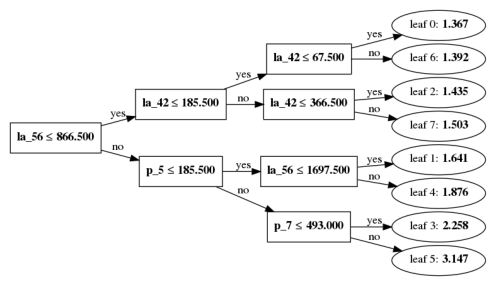

In [ ]:
lgb.plot_tree(model, tree_index=0)

可以清晰地看到决策树的决策过程。在上图中，从中间节点的判断条件可知，下方的叶子节点包含的商品历史销量更大；而上方的叶子节点中的商品历史销量更小。可以看到，对于历史销量大的商品，决策树倾向于给出更大的销量预测值（如最下方的叶子的3.907）。

### LightGBM的特性使用

以上是LightGBM使用的基本流程。上述过程默认使用了LightGBM的一些特性，包括按叶子分割的决策树训练和直方图加速优化。这一小节将回过头来考察这些特性对模型的训练究竟造成了什么样的影响。

#### 决策树的生长方式

首先是按叶子分割的决策树训练。回顾在超参调优的过程中，在决策树的规模限制上，只用到了叶子的数量$num\_leaves$。这是因为LightGBM默认决策树都是按叶子分割进行训练的。当然，LightGBM也提供了对决策树最大深度的限制，由超参数$max\_depth$控制。如果设置$num\_leaves$的值为$2^{max\_depth}$，则决策树等价于按层分割的训练，得到的是一个深度为$max\_depth$的完全二叉树。在本案例中，训练样本量较多，因此使用较为灵活的按叶子分割应该得到更好的结果。我们对这一猜测进行验证。

选取使用nni自动搜参得到的最优超参数，在这组超参数中，$num\_leaves$取值为8，因此加上$max\_depth=3$，就可以让决策树都变成深度为3的完全二叉树。

In [ ]:
params_with_max_depth = {
    "num_leaves":8,
    "learning_rate":0.044462958967770576,
    "min_data_in_leaf":16,
    "lambda_l2":0.06611960419049324,
    "feature_fraction":0.6830879424448291,
    "bagging_fraction":0.7527564678754335,
    "objective": "regression",
    "bagging_freq": 1,
    "max_depth": 3
}

使用相同的迭代轮数重新训练，并观察结果

In [ ]:
params_with_max_depth.update({"num_trees": 53})
model = lgb.train(params=params_with_max_depth,
                  train_set=train_set)
score = model.predict(test_data)
l2_loss = np.mean((score - test_label) ** 2)
l2_loss

/anaconda/envs/lgbm/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5362
[LightGBM] [Info] Number of data points in the train set: 1524500, number of used features: 26
[LightGBM] [Info] Start training from score 1.386903


4.143701924725372

得到验证集上的结果为4.196662，比使用按叶子分割的4.186709差了一些。这说明按叶子分割的训练方式确实学习到了比按层分割更加灵活的决策树结构。当然，由于更换了决策树的生长方式，其他超参数可能也需要进行调整才能得到按层生长的最优结果。不过鉴于本案例中的训练数据充足，一般来说按叶子分割是更好的选择。

#### 直方图带来的加速效果

LightGBM使用直方图优化进行训练，超参数$max\_bin$指定了直方图的区间数量。前面的流程中始终将这个超参数保留为默认值$max\_bin=255$。这里我们调整$max\_bin$，依次尝试$[16, 64, 256, 512, 1024, 2048, 4096, 9192, 18384, 36768, 75536, 151072]$并观察$max\_bin$对训练速度和准确率会造成什么样的影响。

In [ ]:
params_with_max_bin = {
    "num_leaves":8,
    "learning_rate":0.044462958967770576,
    "min_data_in_leaf":16,
    "lambda_l2":0.06611960419049324,
    "feature_fraction":0.6830879424448291,
    "bagging_fraction":0.7527564678754335,
    "objective": "regression",
    "bagging_freq": 1
}
params_with_max_bin.update({"num_trees": 53})
params_with_max_bin.update({"verbose": -1})

In [ ]:
import time

for max_bin in [16, 64, 256, 512, 1024, 2048, 4096, 9192, 18384, 36768, 75536, 151072]:
    params_with_max_bin.update({"max_bin": max_bin})

    #注意，更换不同的max_bin需要重新构造LightGBM的训练数据才能生效
    train_set = lgb.Dataset(train_data, label=train_label)
    test_set = lgb.Dataset(test_data, label=test_label, reference=train_set)

    time_start = time.time()
    model = lgb.train(params=params_with_max_bin,
                  train_set=train_set)
    time_end = time.time()
    score = model.predict(test_data)
    l2_loss = np.mean((score - test_label) ** 2)
    print("with max_bin %d, training time %s seconds, l2_loss %f" % (max_bin, (time_end - time_start), l2_loss))

with max_bin 16, training time 2.506295680999756 seconds, l2_loss 5.045216
with max_bin 64, training time 2.38858699798584 seconds, l2_loss 4.126299
with max_bin 256, training time 2.5584359169006348 seconds, l2_loss 4.183943
with max_bin 512, training time 2.5151989459991455 seconds, l2_loss 4.171627
with max_bin 1024, training time 2.5459041595458984 seconds, l2_loss 4.176913
with max_bin 2048, training time 2.560281753540039 seconds, l2_loss 4.173533
with max_bin 4096, training time 2.718515396118164 seconds, l2_loss 4.169061
with max_bin 9192, training time 2.605896472930908 seconds, l2_loss 4.172087
with max_bin 18384, training time 2.6336991786956787 seconds, l2_loss 4.165019
with max_bin 36768, training time 2.8722853660583496 seconds, l2_loss 4.164789
with max_bin 75536, training time 3.097911834716797 seconds, l2_loss 4.163614
with max_bin 151072, training time 2.7406954765319824 seconds, l2_loss 4.163613


可以看到$max\_bin$增大到一定值以后，训练时间明显变慢，并且也未必能带来准确率上的优势。在以上结果中，测试集上损失函数最低的是使用$max\_bin=64$。除了$max\_bin=16$以外，其他结果的损失函数值没有太大差别，说明准确率对$max\_bin$并不是很敏感。

#### 梯度单边采样(GOSS)

以上过程使用的采样策略为默认的随机等概率采样，即每个决策树随机等概率采样$bagging\_fraction$指定的样本比例。在背景介绍中，我们提到了LightGBM实现了一种更高效的采样方法GOSS，它基于梯度对样本进行采样，从而减少采样带来的准确率损失。GOSS的采样率由两个超参数决定，其中$top\_rate$指定了梯度最大的被保留的样本比例（对应背景介绍部分的$a$），$other\_rate$指定了剩余样本中随机等概率采样的比例（对应背景介绍部分的$b$）。为了比较GOSS和随机等概率采样的效果，将自动搜参得到的最优参数中的$bagging\_fraction$替换为两个$top\_rate$和$other\_rate$的值，并使得$top\_rate+other\_rate=bagging\_fraction$，并设置$boosting\_type$为$goss$（默认的$boosting\_type$为$gbdt$）。

In [ ]:
bagging_fraction = 0.7527564678754335
params_with_goss = {
    "top_rate": 0.3,
    "other_rate": bagging_fraction - 0.3,
    "boosting_type": "goss",
    "num_leaves":8,
    "learning_rate":0.044462958967770576,
    "min_data_in_leaf":16,
    "lambda_l2":0.06611960419049324,
    "feature_fraction":0.6830879424448291,
    "objective": "regression"
}
params_with_goss.update({"num_trees": 53})

In [ ]:
train_set = lgb.Dataset(train_data, label=train_label)
test_set = lgb.Dataset(test_data, label=test_label, reference=train_set)
model = lgb.train(params=params_with_goss,
                  train_set=train_set)
score = model.predict(test_data)
l2_loss = np.mean((score - test_label) ** 2)
l2_loss

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5358
[LightGBM] [Info] Number of data points in the train set: 1524500, number of used features: 24
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 1.386903


4.1686802849049185

上面我们随机选取了top_rate=0.3，使用GOSS的结果略好于同采样比例的等概率随机采样(4.186709)。尝试不同的top_rate，可发现GOSS一致地好于普通的等概率随机采样。

In [ ]:
for top_rate in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    bagging_fraction = 0.7527564678754335
    params_with_goss = {
        "top_rate": top_rate,
        "other_rate": bagging_fraction - top_rate,
        "boosting_type": "goss",
        "num_leaves":8,
        "learning_rate":0.044462958967770576,
        "min_data_in_leaf":16,
        "lambda_l2":0.06611960419049324,
        "feature_fraction":0.6830879424448291,
        "objective": "regression"
    }
    params_with_goss.update({"num_trees": 53, "verbose":-1})
    train_set = lgb.Dataset(train_data, label=train_label)
    test_set = lgb.Dataset(test_data, label=test_label, reference=train_set)
    model = lgb.train(params=params_with_goss,
                      train_set=train_set)
    score = model.predict(test_data)
    l2_loss = np.mean((score - test_label) ** 2)
    print("l2_loss with top rate %f = %f" % (top_rate, l2_loss))

l2_loss with top rate 0.100000 = 4.162216
l2_loss with top rate 0.200000 = 4.145472
l2_loss with top rate 0.300000 = 4.168680
l2_loss with top rate 0.400000 = 4.174883
l2_loss with top rate 0.500000 = 4.197601
l2_loss with top rate 0.600000 = 4.183351
